# Estimating the value of $\pi$ using a Monte Carlo technique 

The program picks random points in the area $[-1,1] \times [-1,1]$, and determines which fraction of these are within the unit circle. This in turn gives a measure of $\pi$ with associated statistical uncertainty. Performing such "experiments" many times not only gives the value of $\pi$, but also a feel for the use of Monte Carlo, and experience in calculating averages, RMSs, and the error on these.
The first part of the program is mostly for illustration, while the exercise is question 4 on using this in higher dimension problems.

For more information see:
- P. R. Bevington: page 75-78

***

### Authors: 
- Troels C. Petersen (Niels Bohr Institute)

### Date:    
- 06-01-2024 (latest update)

In [239]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
from scipy import stats

sys.path.append('../AppStat2023/External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

and define the parameters of the program:

In [240]:
save_plots = True         # Determining if plots are saved or not
r = np.random
r.seed(42)

# Set parameters:
N_experiments = 100        # Number of "experiments" determining pi
N_points      = 2000       # Number of points per experiment in determining pi

pi_true = np.pi

In [241]:
def fit_and_plot(f, x, y, sy, par_guess, labels):
    """Function for making and plotting a chi2-fit."""
    
    Minuit.print_level = 1

    chi2fit = Chi2Regression(f, x, y, sy)

    minuit_chi2 = Minuit(chi2fit, **par_guess)
    minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
    minuit_chi2.migrad()           # This is where the minimisation is carried out! Put ";" at the end to void output


    for name in minuit_chi2.parameters :
        value, error = minuit_chi2.values[name], minuit_chi2.errors[name]
        print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")

    # Get Chi2 value:
    chi2_value = minuit_chi2.fval            # The value minimised, i.e. Chi2 or -2*LogLikeliHood (LLH) value

    # Get number of degrees-of-freedom (Ndof):
    Ndof_value = len(y) - minuit_chi2.nfit

    Prob_value = stats.chi2.sf(chi2_value, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
    print(f"Chi2 value: {chi2_value:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value}")

    fig, ax = plt.subplots(figsize=(9, 6))  # figsize is in inches
    ax.errorbar(x, y, yerr=sy, label='Data', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

    # Set the figure texts; xlabel, ylabel and title.
    ax.set(xlabel=f"{labels[0]}", # the label of the y axis
        ylabel=f"{labels[1]}",  # the label of the y axis
        title=f"{labels[2]}")

    # Adding fit function to plot:
    x_axis = np.linspace(np.min(x), np.max(x), 1000)
    ax.plot(x_axis, f(x_axis, *minuit_chi2.values[:]), '-r', label='Chi2 fit model result') 

    # Adding fit results to plot:
    d = {'Chi2':     minuit_chi2.fval  ,
        'ndf':      len(y)-minuit_chi2.nfit,
        'Prob':     stats.chi2.sf(minuit_chi2.fval, len(y)-minuit_chi2.nfit),
        }

    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.62, 0.95, text, ax, fontsize=12)

    ax.legend(loc='upper left', fontsize=12);
    fig.tight_layout()

## Loop over process:

In [242]:
pi_dist    = np.zeros(N_experiments)
hit_dist_x = np.zeros(N_points)
hit_dist_y = np.zeros(N_points)

for iexp in range(N_experiments):

    # Fill random numbers into square, and see how many are inside unit circle:
    hit_dist_x = r.uniform(-1, 1, N_points)
    hit_dist_y = r.uniform(-1, 1, N_points)
    Nhit = np.sum(hit_dist_x**2 + hit_dist_y**2 < 1)
    
    # Calculate the fraction of points within the circle and its error:
    f  = Nhit / N_points
    sf = np.sqrt(f*(1-f)/N_points)         # Remind yourself the uncertainty on a fraction n/N!!!

    # From this we can get pi and its error, and save it:
    pi_estm  = 4.0 * f
    pi_error = 4.0 * sf
    pi_dist[iexp] = pi_estm

    # Print first couple of pi measurements:
    if (iexp < 5) :
        print(f"{iexp:2d}. pi estimate:   {pi_estm:7.4f} +- {pi_error:6.4f}")

 0. pi estimate:    3.1400 +- 0.0367
 1. pi estimate:    3.1680 +- 0.0363
 2. pi estimate:    3.1460 +- 0.0367
 3. pi estimate:    3.1040 +- 0.0373
 4. pi estimate:    3.1400 +- 0.0367


In [243]:
if (N_experiments > 1):
    pi_mean = pi_dist.mean()
    pi_std = pi_dist.std(ddof=1)
    pi_standard_error = pi_std / np.sqrt(N_experiments)
    print(f"The {N_experiments:d} experiments yield: pi = {pi_mean:7.5f} +- {pi_standard_error:7.5f}     (std = {pi_std:5.3f})")
    print(f"and the agreement with the true value of pi is: {(pi_mean - pi_true) / pi_standard_error:6.2f} sigma")
else :
    print("Since only one experiment was done, no average and RMS can be calculated.")

The 100 experiments yield: pi = 3.14332 +- 0.00370     (std = 0.037)
and the agreement with the true value of pi is:   0.47 sigma


## Plot the histograms:

Distribution of points from one experiment:

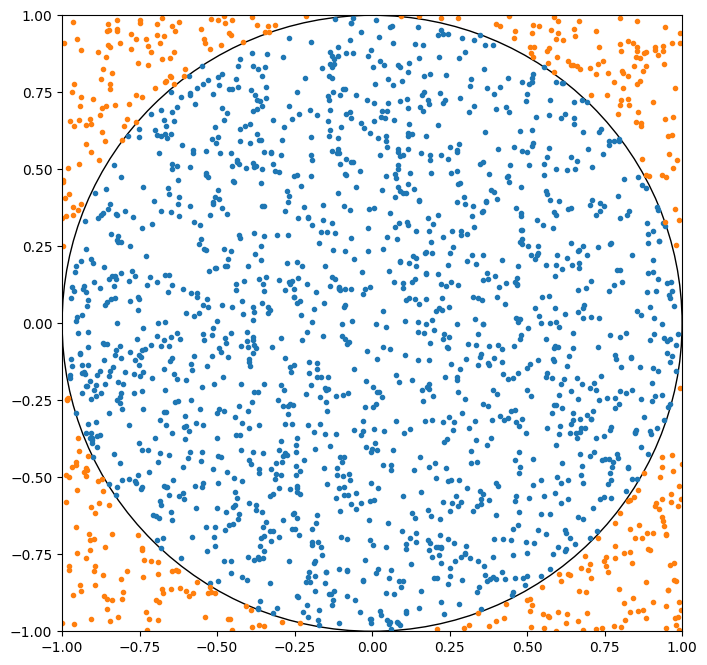

In [244]:
fig1, ax1 = plt.subplots(figsize=(8, 8))    

# Make mask of points inside vs outside the circle:
mask_inside = hit_dist_x**2 + hit_dist_y**2 < 1
mask_outside = ~mask_inside

# Make scatter plot of points:
ax1.plot(hit_dist_x[mask_inside], hit_dist_y[mask_inside], '.')
ax1.plot(hit_dist_x[mask_outside], hit_dist_y[mask_outside], '.')
ax1.set(xlim=(-1, 1), ylim=(-1,1))

# Add circle to plot:
ax1.add_artist(plt.Circle((0, 0), 1, color='k', fill=False))

if save_plots: 
    fig1.savefig("HitDist.pdf")

[Text(0.5, 0, 'pi'),
 Text(0, 0.5, 'frequency / 0.01'),
 Text(0.5, 1.0, 'Distribution of simulated values of pi')]

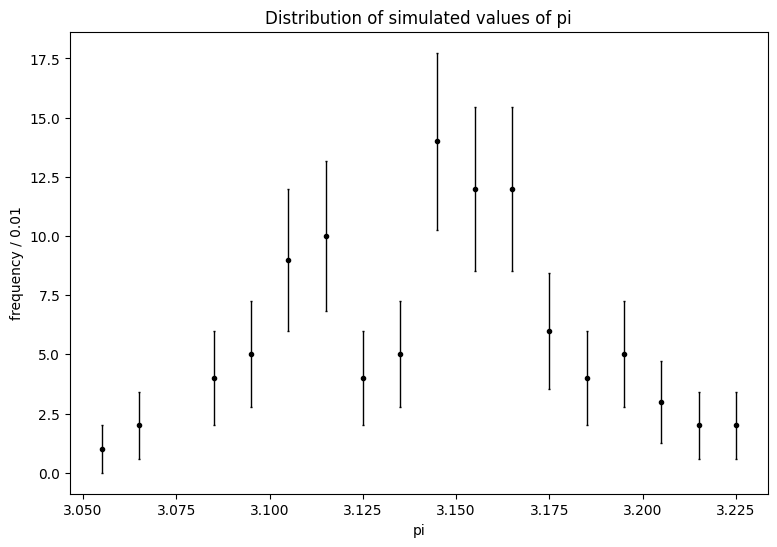

In [245]:
N_bins = 20
xmin = 3.05
xmax = 3.25
binwidth = (xmax-xmin)/N_bins

counts, bin_edges = np.histogram(pi_dist, bins=N_bins, range=(xmin,xmax))
x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
y = counts[counts>0]
sy = np.sqrt(counts[counts>0])   # NOTE: We (naturally) assume that the bin count is Poisson distributed.

fig, ax = plt.subplots(figsize=(9, 6))
ax.errorbar(x, y, yerr=sy, fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)
ax.set(xlabel="pi", ylabel=f"frequency / {binwidth:.2f}", title="Distribution of simulated values of pi")

Fit value: mu = 3.14335 +/- 0.00562
Fit value: sigma = 0.04686 +/- 0.00533
Chi2 value: 14.2   Ndof = 15    Prob(Chi2,Ndof) = 0.5138503985215528


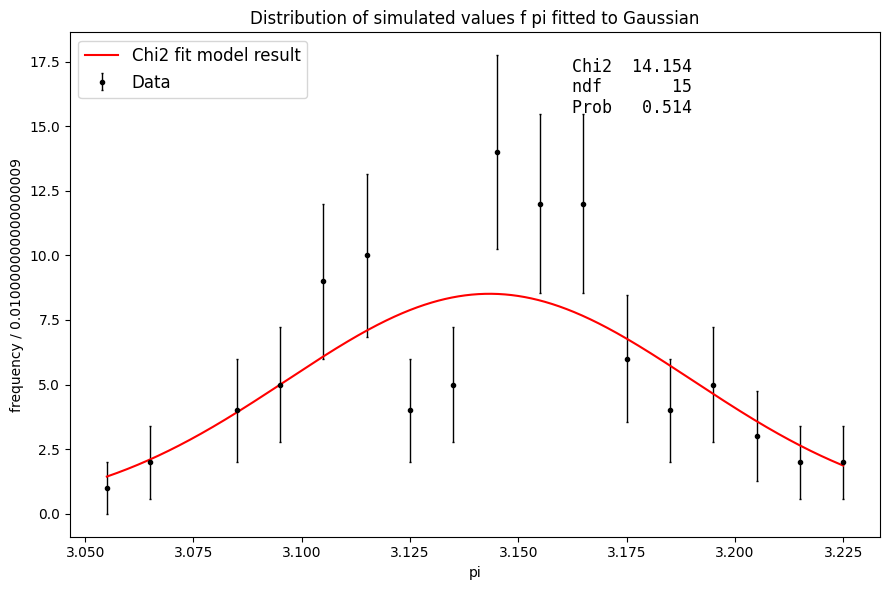

In [246]:
def gauss_pdf(x, mu, sigma) :
    """Gaussian"""
    N = (xmax-xmin)/N_bins * len(pi_dist)
    return  N * 1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2)

fit_and_plot(gauss_pdf, x, y, sy, {"mu":3, "sigma":0.1}, ["pi", f"frequency / {binwidth}", "Distribution of simulated values f pi fitted to Gaussian"])

In [247]:
def calculate_factor(dim):
    fac_dist    = np.zeros(N_experiments)

    for iexp in range(N_experiments):

        squared = 0

        # Fill random numbers into square, and see how many are inside unit circle:
        for i in range(dim):
            hist_dist = r.uniform(-1, 1, N_points)
            squared += hist_dist**2
        
        Nhit = np.sum(squared < 1)
        #hit_dist_x = r.uniform(-1, 1, N_points)
        #hit_dist_y = r.uniform(-1, 1, N_points)
        #Nhit = np.sum(hit_dist_x**2 + hit_dist_y**2 < 1)
        
        # Calculate the fraction of points within the circle and its error:
        f  = Nhit / N_points
        sf = np.sqrt(f*(1-f)/N_points)         # Remind yourself the uncertainty on a fraction n/N!!!

        # From this we can get pi and its error, and save it:
        fac_estm  = 2**(dim) * f
        fac_error = 2**(dim) * sf
        fac_dist[iexp] = fac_estm

    fac_mean = fac_dist.mean()
    fac_std = fac_dist.std(ddof=1)
    fac_standard_error = fac_std / np.sqrt(N_experiments)
    
    return fac_mean, fac_standard_error

In [248]:
dimension = np.arange(2, 11)
fac_array = np.zeros(len(dimension))
d_fac_array = np.zeros(len(dimension))

for i, d in enumerate(dimension):
    fac, d_fac = calculate_factor(d)
    fac_array[i] = fac
    d_fac_array[i] = d_fac

[Text(0.5, 0, 'Dimensions'),
 Text(0, 0.5, 'Factor'),
 Text(0.5, 1.0, 'Factor in formula for (hyper)volume of (hyper)spheres')]

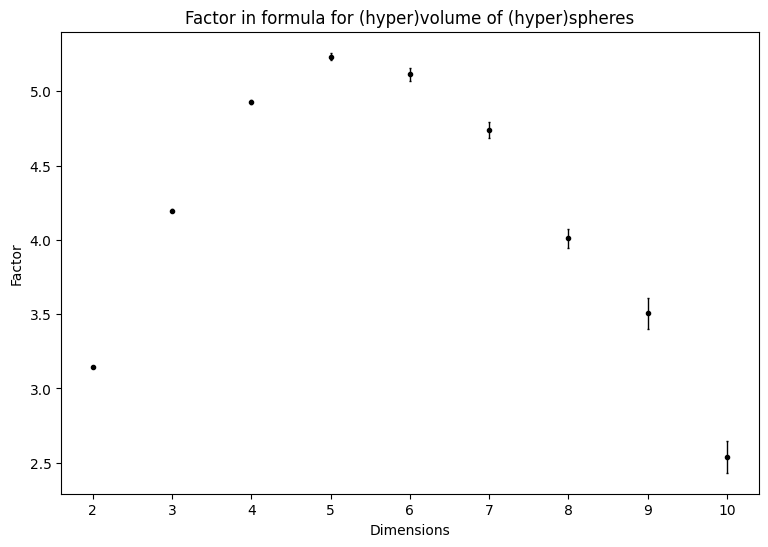

In [249]:
fig, ax = plt.subplots(figsize=(9, 6))  # figsize is in inches
ax.errorbar(dimension, fac_array, yerr=d_fac_array, label='Data', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)
ax.set(xlabel="Dimensions", ylabel="Factor", title="Factor in formula for (hyper)volume of (hyper)spheres")

In [251]:
print(f"The agreement with the true value of the factor for 3 dimensions is is: {(fac_array[1]/np.pi - 4/3) / d_fac_array[1]/np.pi:6.2f} sigma")

The agreement with the true value of the factor for 3 dimensions is is:   0.06 sigma


***

First acquaint yourself with the program, and make sure that you understand what the parameters `N_experiment` and `N_points` refer to! Also, before running the program,
calculate what precision you expect on pi in each experiment, when using the number of points chosen in the program (i.e. 2000 points).

Then, run the program, and then take a look at the result... which requires that you fill in the calculations yourself!

# Initial simple questions:

0. Plot the distribution of $\pi$ values obtained.

1. Try to run 100 experiments with 2000 points in each. What is the expected approximate uncertainty on $\pi$ in each experiment? Does the result agree with what you calculated before running the program? What is the uncertainty on the AVERAGE of all 100 experiments?

It is a binomial uncertainty because we have either success (point is in circle) or failure (point is outside circle). Hence:

$$\sigma(f) = \sqrt{\frac{f(1-f)}{N}}$$

2. How do you expect the values of $\pi$ to distribute themselves? And is this the case here?

I expect the distribution to be Gaussian due to the Central Limit Theorem. This is becuase I have 2000 points in each experiment so there are many contributions to the simulated value of pi.

I have performed a $\chi^2$-fit to a Gaussian and it yields a p-value of 51.4 %. Hence, it is very likely that the distribution of simulated values of pi follow a Gaussian distribution.


3. Does it make any difference on the precision of the final $\pi$ value, whether you make many experiments with few points, or one experiment with many points, as long as the product of `N_experiment` $\times$ `N_points` remains constant?

Many experiments with few points (10000 experiments with 20 points): $\pi = 3.14478 \pm 0.00368$

One experiment with many points (1 experiment with 200000) points: $\pi = 3.1439 \pm 0.0037$

They are almost completely equally precise so it doesn't make a difference. 

# The real exercise question:

4. Now try to use this method in three dimensions to estimate the constant in front of the $r^3$ expression for the volume. Do you get $\frac{4}{3} \pi$?
    Increase the dimensionality (say up to 10), and see if you can figure out the constants needed to calculate the hyper-volumes!

    HINT: I'll reveal that for `N_dim` of 4 and 5, the constant contains $\pi^2$ and some simple rational fraction, while for `N_dim` 6 and 7, it contains $\pi^3$ and a
      rational fraction.

# Learning points:

This is an exercise in using simulation for numerical estimates, that are otherwise rather complicated. Especially in high dimensionality, it can be hard to produce good solutions, while simulation (such as this exercise) gives an easier alternative.

From the exercise you should:
1. Get experience with a simulation solution example.
2. Train estimation of uncertainties on multiple estimates (here of pi).
3. Exercise hypothesis testing, comparing simulated estimates to multiple hypothesis (rational fractions). 

Following this exercise, you should feel comfortable in working out a simulated answer to a problem/case.